In [12]:
import rasterio
import pandas as pd
import geopandas as gpd
import csv
import numpy as np
import os
from rasterio.merge import merge
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Polygon, MultiPolygon, Point, mapping
import ast
from rasterio.mask import mask, raster_geometry_mask


def align_extent_raster(reference_path, tiff_to_be_aligned):
    """
    Aligns the extent of a raster to match that of a reference raster.

    Parameters:
    ----------
    raster_reference : rasterio.io.DatasetReader
        The reference raster whose extent and profile are used.
    tiff_to_be_aligned : rasterio.io.DatasetReader
        The raster that needs to be aligned to the reference raster.

    Returns:
    -------
    np.array
        The aligned raster is returned as an array.
    """
    with rasterio.open(reference_path, "r") as raster_reference:

        bounds1 = raster_reference.bounds
        
    transform_2 = tiff_to_be_aligned.transform

    window = rasterio.windows.from_bounds(*bounds1, transform=transform_2)

    smaller_array = tiff_to_be_aligned.read(window=window, boundless=True) 
    return smaller_array

def build_class_rurub_arr(rururb_arr):
    class_rur_urb_arr = np.copy(rururb_arr)
    #dealing with nodta
    class_rur_urb_arr[rururb_arr>30] = -1

    class_rur_urb_arr[(rururb_arr>=1) & (rururb_arr<=7)] = 1
    class_rur_urb_arr[(rururb_arr>=8) & (rururb_arr<15)] = 2
    class_rur_urb_arr[(rururb_arr>=15) & (rururb_arr<22)] = 3
    class_rur_urb_arr[(rururb_arr>=22) & (rururb_arr<=30)] = 4
    return(class_rur_urb_arr)


import requests
from time import sleep
#{6: 'Sudan', 8: 'Angola', 29: 'Benin', 35: 'Botswana', 42: 'Burkina Faso', 45: 'Cameroon', 47: 'Cape Verde', 49: 'Central African Republic',
#50: 'Chad', 58: 'Comoros', 59: 'Congo', 66: "Côte d'Ivoire", 68: 'Democratic Republic of the Congo', 70: 'Djibouti', 74: 'South Sudan',
#76: 'Equatorial Guinea', 77: 'Eritrea', 79: 'Ethiopia', 89: 'Gabon', 90: 'Gambia', 94: 'Ghana', 105: 'Guinea-Bissau', 106: 'Guinea', 133: 'Kenya',
#142: 'Lesotho', 144: 'Liberia', 150: 'Madagascar', 152: 'Malawi', 155: 'Mali', 159: 'Mauritania', 160: 'Mauritius', 170: 'Mozambique', 172: 'Namibia',
#181: 'Niger', 182: 'Nigeria', 217: 'Senegal', 220: 'Seychelles', 221: 'Sierra Leone', 226: 'Somalia', 227: 'South Africa', 235: 'Swaziland', 243: 'Togo',
#253: 'Uganda', 257: 'United Republic of Tanzania', 270: 'Zambia', 271: 'Zimbabwe', 4: 'Algeria', 43: 'Burundi', 102: 'Abyei', 145: 'Libya', 169: 'Morocco',
#205: 'Rwanda', 214: 'Sao Tome and Principe', 248: 'Tunisia', 268: 'Western Sahara', 40760: "Hala'ib triangle", 40762: "Ma'tan al-Sarra", 40765: 'Egypt',
#61013: 'Ilemi triangle'}

def get_geodata(adm0, admin2: bool=False):
    """
    creates a dataframe with the wfp geometries
    :param adm0: gets the country code as set from wfp, e.g., 79 for Ethiopia, and 182 for Nigeria
    :param admin2: gets both admin2 and admin1 data; default is False
    :return: a dataframe with the wfp geometries
    """

    # for admin1
    req = requests.get(f"https://api.vam.wfp.org/geodata/GetGeoAdmins?adm0={adm0}&admcode={adm0}", headers = {'User-agent': f'your bot {adm0}'})
    req.raise_for_status()  # raises exception when not a 2xx response
    # if req.status_code != 204:
    #     return req.json()
    sleep(10)

    geo_df = gpd.GeoDataFrame.from_features(req.json()['features'])

    # for admin2
    if admin2==True:
        # rename columns
        geo_df = geo_df.rename(columns={'geometry': 'geometry_adm1', "Code": "Code_adm1", "Name": "Name_adm1"})
        #create an empty df to use
        all_adm2 = pd.DataFrame(columns=['geometry', 'Code', 'Name', 'Code_adm1'])
        for code in geo_df.Code_adm1:
            # print(code)
            req_adm2 = gpd.GeoDataFrame.from_features(requests.get(f"https://api.vam.wfp.org/geodata/GetGeoAdmins?adm0={adm0}&admcode={code}").json()["features"])
            req_adm2['Code_adm1'] = code
            all_adm2 = pd.concat([req_adm2, all_adm2])
            sleep(0.5)
        #merge
        geo_df = pd.merge(geo_df, all_adm2, on='Code_adm1')
    
    geo_df.set_crs('EPSG:4326', inplace = True)
    return geo_df


In [59]:
#merge accessibilities into a single raster
country_num_ls = os.listdir('./computed_acc')
for i, country_code in enumerate(country_num_ls):
    if len(country_code) > 3:
        continue
    # Define paths
    for path in os.listdir(f"../shared_data/worldpop_rasters/{country_code}"):
        if path.endswith('cropped.tif'):
            chosen_path = path
    wpp_path = f"../shared_data/worldpop_rasters/{country_code}/{chosen_path}"
    with rasterio.open(wpp_path, "r") as src:
        worldpop_arr = src.read()[0]
        worldpop_arr = np.where(worldpop_arr<0, 0, worldpop_arr)
    
    acc_path_wtt = f"./computed_acc/{country_code}/shortest_walk_tt.tif"
    acc_path_mtt = f"./computed_acc/{country_code}/shortest_moto_tt.tif"
    acc_path_cum = f"./computed_acc/{country_code}/acc_pure_cumul_moto.tif"
    acc_path_ent = f"./computed_acc/{country_code}/entropy_mod_4h_moto.tif"
    
    # Load the raster data

    acc_raster_mtt = rasterio.open(acc_path_mtt, 'r')
    acc_raster_cum = rasterio.open(acc_path_cum, 'r')
    acc_raster_ent = rasterio.open(acc_path_ent, 'r')
    with rasterio.open(acc_path_wtt, 'r') as f:
        acc_wtt = align_extent_raster(wpp_path, f)[0]
        
    with rasterio.open(acc_path_mtt, 'r') as f:
        acc_mtt = align_extent_raster(wpp_path, f)[0]
        
    with rasterio.open(acc_path_cum, 'r') as f:
        acc_cum = align_extent_raster(wpp_path, f)[0]

    with rasterio.open(acc_path_ent, 'r') as f:
        acc_ent = align_extent_raster(wpp_path, f)[0]

    wpp_rast = rasterio.open(wpp_path, 'r')
    wpp_mat = wpp_rast.read()[0]
    wpp_mat[wpp_mat<0] = np.nan
    transform = wpp_rast.transform
    bounds = wpp_rast.bounds

    rur_urb_rast = rasterio.open('../data/urban_rural_catchment_areas.tif')
    rur_urb_arr =  align_extent_raster(wpp_path, rur_urb_rast)[0]
    rur_urb_arr = rur_urb_arr.astype(np.int8) 
    rur_urb_arr[wpp_mat < 0] = -1

    # Bild the 4-class rural-urban classification
    class_rur_urb_arr = build_class_rurub_arr(rur_urb_arr)
    

    with rasterio.open(f'../data/data_interface/acc_rasters/acc_{country_code}.tif',"w",driver="GTiff", height=wpp_rast.shape[0],
                       width=wpp_rast.shape[1], count=6, dtype=np.float32,
                       crs=wpp_rast.crs, transform=transform, nodata = np.nan) as dst:
        
        dst.write_band(1, acc_wtt) 
        dst.write_band(2, acc_mtt)
        dst.write_band(3, acc_cum) 
        dst.write_band(4, acc_ent) 
        dst.write_band(5, wpp_mat)
        dst.write_band(6, class_rur_urb_arr)


In [153]:
#merge accessibilities into a single raster
country_num_ls = os.listdir('./computed_acc')
ls_wtt = []
ls_mtt = []
ls_cum = []
ls_ent = []
rururb_ls = []
wpp_ls = []
for i, country_code in enumerate(country_num_ls):
    if len(country_code) > 3:
        continue
    # Define paths
    print(country_code)
    for path in os.listdir(f"../shared_data/worldpop_rasters/{country_code}"):
        if path.endswith('cropped.tif'):
            chosen_path = path
    wpp_path = f"../shared_data/worldpop_rasters/{country_code}/{chosen_path}"
    wpp_ls.append(rasterio.open(wpp_path, "r"))
    
    acc_path_wtt = f"./computed_acc/{country_code}/shortest_walk_tt.tif"
    acc_path_mtt = f"./computed_acc/{country_code}/shortest_moto_tt.tif"
    acc_path_cum = f"./computed_acc/{country_code}/acc_pure_cumul_moto.tif"
    acc_path_ent = f"./computed_acc/{country_code}/entropy_mod_4h_moto.tif"
    
    # Load the raster data

    ls_wtt.append(rasterio.open(acc_path_wtt, 'r'))
    ls_mtt.append(rasterio.open(acc_path_mtt, 'r'))
    ls_cum.append(rasterio.open(acc_path_cum, 'r'))
    ls_ent.append(rasterio.open(acc_path_ent, 'r'))

wtt_merged, wtt_transform = merge(ls_wtt, nodata = np.nan)
wtt_merged = wtt_merged[0]
wtt_merged[np.isnan(wtt_merged)] = -1
wtt_merged = wtt_merged.astype(np.int32)

mtt_merged, mtt_transform = merge(ls_mtt, nodata = np.nan)
mtt_merged = mtt_merged[0]
mtt_merged[np.isnan(mtt_merged)] = -1
mtt_merged = mtt_merged.astype(np.int32)

cum_merged, cum_transform = merge(ls_cum, nodata = np.nan)
cum_merged = cum_merged[0]
cum_merged[np.isnan(cum_merged)] = -1
cum_merged = cum_merged.astype(np.int32)

ent_merged, ent_transform = merge(ls_ent, nodata = np.nan)
ent_merged = ent_merged[0]
ent_merged[np.isnan(ent_merged)] = -1
ent_merged = ent_merged.astype(np.float32)

wpp_merged, wpp_transform = merge(wpp_ls, nodata = np.nan)
wpp_merged = wpp_merged[0]
wpp_merged[np.isnan(wpp_merged)] = -1
wpp_merged = wpp_merged.astype(np.float32)

with rasterio.open(f'../data/data_interface/acc_rasters/walk_tt_africa.tif',"w",driver="GTiff", height=wtt_merged.shape[0],
                       width=wtt_merged.shape[1], count=1, dtype=np.int32,
                       crs=ls_wtt[0].crs, transform=wtt_transform, nodata = -1) as dst:
        
        dst.write_band(1, wtt_merged) 

with rasterio.open(f'../data/data_interface/acc_rasters/moto_tt_africa.tif',"w",driver="GTiff", height=mtt_merged.shape[0],
                       width=mtt_merged.shape[1], count=1, dtype=np.int32,
                       crs=ls_mtt[0].crs, transform=mtt_transform, nodata = -1) as dst:
        
        dst.write_band(1, mtt_merged) 

with rasterio.open(f'../data/data_interface/acc_rasters/cumulative_africa.tif',"w",driver="GTiff", height=cum_merged.shape[0],
                       width=cum_merged.shape[1], count=1, dtype=np.int32,
                       crs=ls_cum[0].crs, transform=cum_transform, nodata = -1) as dst:
        
        dst.write_band(1, cum_merged) 

with rasterio.open(f'../data/data_interface/acc_rasters/entropy_africa.tif',"w",driver="GTiff", height=ent_merged.shape[0],
                       width=ent_merged.shape[1], count=1, dtype=np.float32,
                       crs=ls_ent[0].crs, transform=ent_transform, nodata = -1) as dst:
        
        dst.write_band(1, ent_merged) 

with rasterio.open(f'../data/data_interface/acc_rasters/population_africa.tif',"w",driver="GTiff", height=wpp_merged.shape[0],
                       width=wpp_merged.shape[1], count=1, dtype=np.float32,
                       crs=wpp_ls[0].crs, transform=wpp_transform, nodata = -1) as dst:
        
        dst.write_band(1, wpp_merged) 


with rasterio.open('../data/urban_rural_catchment_areas.tif', 'r') as f:
    rururb_mat = align_extent_raster('../data/data_interface/acc_rasters/population_africa.tif', f)[0]
    rururb_mat = rururb_mat.astype(np.int8)
    rururb_mat[rururb_mat < 0] = -1
    rururb_mat[rururb_mat < 0] = -1
    rururb_mat[np.isnan(rururb_mat)] = -1
    rururb_mat = build_class_rurub_arr(rururb_mat)
    
with rasterio.open(f'../data/data_interface/acc_rasters/rur_urb_africa.tif',"w",driver="GTiff", height=rururb_mat.shape[0],
                       width=rururb_mat.shape[1], count=1, dtype=np.int8,
                       crs=wpp_rast.crs, transform=transform, nodata = -1) as dst:
        
        dst.write_band(1, rururb_mat) 

zmb
cpv
stp
eth
nam
tcd
cog
lbr
sdn
dji
dza
mar
mrt
ago
mus
mli
lby
zwe
syc
som
bfa
tza
mwi
bdi
zaf
gin
nga
ben
egy
com
lso
sle
rwa
ssd
ner
gab
cod
ken
esh
uga
tgo
cmr
gha
gmb
gnb
mdg
civ
swz
sen
eri
caf
moz
bwa
gnq
tun


4.0


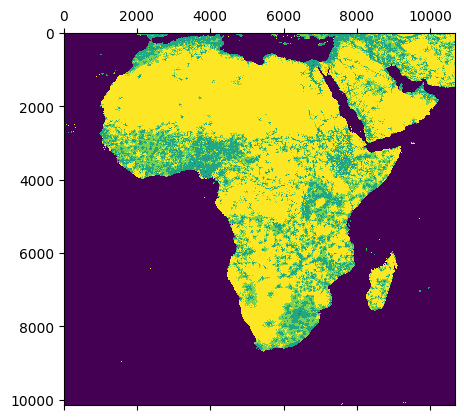

In [154]:
a = np.copy(rururb_mat).astype(np.float32)

# a[a<0] = np.nan
print(a.max())
plt.matshow(a)
plt.show()

In [50]:
IPC_gdf = gpd.read_file('../data/IPC_admin_1.geojson')
RWI_gdf = gpd.read_file('../data/RWI_admin_1.geojson')
IPC_RWI = IPC_gdf.merge(RWI_gdf, left_on = 'shortest_tt_walk', right_on = 'shortest_tt_walk')
IPC_RWI = IPC_RWI.drop(columns = [col for col in IPC_RWI.columns if col.endswith('_y')])
IPC_RWI = IPC_RWI.rename(columns={col:col[:-2] for col in IPC_RWI.columns if col.endswith('_x')})
IPC_RWI.to_file('../data/RWI_IPC_admin_1.geojson')

In [107]:
# WRITE OSM AND WFP POINTS TO FILE
country_num_ls = os.listdir('./computed_acc')

market_WFP_all = pd.read_csv('../shared_data/markets_MFI_africa.csv')
market_price = pd.read_csv('../shared_data/markets_price_africa.csv')

market_WFP = pd.concat([market_WFP_all, market_price]).drop_duplicates(subset = 'MarketId', keep = 'first')

market_WFP_all['geometry'] = [Point(xy) for xy in zip(market_WFP_all.Longitude, market_WFP_all.Latitude)]

market_WFP_all = gpd.GeoDataFrame(market_WFP_all, geometry = 'geometry')

market_WFP_all.drop(['Latitude', 'Longitude', 'Admin1', 'Admin2', 'MarketId'], inplace = True, axis = 1)
wfp_country_num = 0

market_OSM = gpd.GeoDataFrame()

# Define search radius in meters

for i, country_code in enumerate(country_num_ls):
    count = 0  # Counter for points within the radius
    if len(country_code) !=3:
        continue
    market_OSM_i = gpd.read_file('../shared_data/africa_markets/markets/'+country_code+'_markets_shops.geojson')

    crs = market_OSM_i.crs
    utm_crs = market_OSM_i.estimate_utm_crs()
    
    market_OSM_i = market_OSM_i.to_crs(utm_crs)
    # get centroids if markets are polygons
    market_OSM_i['geometry'] = market_OSM_i['geometry'].centroid
    market_OSM_i = market_OSM_i.to_crs(crs)
    
    # load the country borders
    country_borders = gpd.read_file('../shared_data/africa_markets/borders/'+country_code+'.geojson')
    country_borders = country_borders.to_crs(crs)
    market_OSM_i['country'] = [country_borders.ADM0_NAME[0] for _ in range(len(market_OSM_i))]
    # Get the WFP markets from the country considered

    if i == 0:
        market_OSM = market_OSM_i
        market_WFP_all = market_WFP_all.set_crs(crs)
        market_WFP_country= market_WFP_all.sjoin(country_borders)
        market_WFP_country.reset_index(inplace = True)
        market_WFP = market_WFP_country
        prev_len = len(market_WFP)
        if prev_len>0:
            wfp_country_num+=1

    else:
        market_OSM = pd.concat([market_OSM, market_OSM_i])

        market_WFP_country= market_WFP_all.sjoin(country_borders)
        market_WFP_country.reset_index(inplace = True)
        market_WFP = pd.concat([market_WFP, market_WFP_country])
        if len(market_WFP) > prev_len:
            wfp_country_num+=1
            prev_len = len(market_WFP)
    
    market_OSM_i = market_OSM_i.to_crs(market_OSM_i.estimate_utm_crs())
    market_WFP_country = market_WFP_country.to_crs(market_OSM_i.estimate_utm_crs())

    # Build spatial index for gdf2
    sindex = market_OSM_i.sindex  
    
market_types = []
for i in range(len(market_OSM)):
    amenity = market_OSM['amenity'].iloc[i]
    shop = market_OSM['shop'].iloc[i]
    if amenity == None and shop != None:
        market_types.append(shop)
    elif amenity != None and shop == None:
        market_types.append(amenity)
    elif amenity == None and shop == None:
        try:
            market_types.append(ast.literal_eval(market_OSM.iloc[i, 2])[0]["reltags"]["amenity"])
        except:
            market_types.append(np.nan)
    else: # if both fields have info
        if amenity != "marketplace": # if it is not a marketplace then take the shop field
            market_types.append(shop)
        else:
            market_types.append(amenity) # if it is a marketplace, then take 
                                                # the more generic marketplace info since for others we don't have this info
market_OSM['market_type'] = market_types
market_OSM = market_OSM.loc[:, ['market_type','geometry']]

market_WFP = market_WFP.loc[:, ['MarketName','geometry']]

market_WFP.to_file('../data/markets_WFP_africa.geojson')
market_OSM.to_file('../data/markets_OSM_africa.geojson')

Skipping field opening_hours:covid19: unsupported OGR type: 10
/home/rbenassai/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


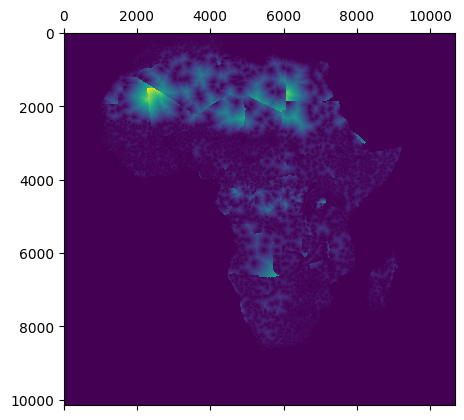

In [127]:
with rasterio.open(f'../data/data_interface/acc_rasters/walk_tt_africa.tif', 'r') as src:
    img = src.read()[0]
plt.matshow(img)
plt.show()
# print(img[0])

In [122]:
fig, ax = plt.subplots()
market_WFP.plot(ax = ax)
market_OSM.plot(ax = ax)

<Axes: >

Error in callback <function flush_figures at 0x7f2ae8582340> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Taking data for Vasia and WFP

In [2]:
country_ls = os.listdir('./computed_acc')
global_gdf = gpd.GeoDataFrame()

In [11]:

# List of countries
# Set up a single plot
wrong_numbers = {74:70001, 6: 40764, 217:278}
# norm = BoundaryNorm(percentile_bins, cmap.N)
request_fails = []
africa_gdf = gpd.read_file('../shared_data/africa_borders/afr_g2014_2013_0.shp')

# Second pass: plot the data
for country_iso3 in country_ls:
    # print(country_iso3)

    try:
        country_num = int(africa_gdf.loc[africa_gdf['ISO3'] == country_iso3.upper()]['ADM0_CODE'].values[0])
        print('country num: ', country_num)
    except:
        continue   
    print(country_iso3)
    # Load WorldPop to get extent and transform
    for path in os.listdir(f"../shared_data/worldpop_rasters/{country_iso3}"):
        if path.endswith('cropped.tif'):
            chosen_path = path
    wpp_path = f"../shared_data/worldpop_rasters/{country_iso3}/{chosen_path}"
    with rasterio.open(wpp_path, "r") as src:
        transform = src.transform
        worldpop_arr = src.read()[0]
        worldpop_arr = np.where(worldpop_arr<0, 0, worldpop_arr)
        
    # print('loaded population')
    en_path = f'./computed_acc/{country_iso3}/entropy_mod_4h_moto.tif'
    shortest_tt_path = f'./computed_acc/{country_iso3}/shortest_moto_tt.tif'
    shortest_walinkg_tt_path = f'./computed_acc/{country_iso3}/shortest_walk_tt.tif'
    acc_path_pure_cumul = f'./computed_acc/{country_iso3}/acc_pure_cumul_moto.tif'
    
    with rasterio.open(en_path, 'r') as f:
        entropy = align_extent_raster(wpp_path, f)[0]

    # print('loaded entropy')

    with rasterio.open(shortest_tt_path, 'r') as f:
        shortest_tt = align_extent_raster(wpp_path, f)[0]


    with rasterio.open(shortest_walinkg_tt_path, 'r') as f:
        shortest_walking_tt = align_extent_raster(wpp_path, f)[0]

    # print('loaded shortest tt.')

    with rasterio.open(acc_path_pure_cumul, 'r') as f:
        acc_pure_cumul = align_extent_raster(wpp_path, f)[0]

    # Load country boundaries
    try:
        if country_num in wrong_numbers.keys():
            correct_num = wrong_numbers[country_num]
        else:
            correct_num = country_num
        country_adm_gdf = get_geodata(correct_num, True)
        country_adm_gdf['country_num'] = np.ones(len(country_adm_gdf))*country_num
        
    except Exception as e:
        print('Exception: ', e)
        request_fails.append(country_iso3)
        continue

    short_tt_admin = []
    entropy_adm = []
    pure_cumul_adm = []
    walk_tt_adm = []
    populations = []
    
    for i, poly in enumerate(country_adm_gdf['geometry']):
        wpp_rast = rasterio.open(wpp_path, "r")
        
        clipped_wpp, _, _ =  raster_geometry_mask(wpp_rast, [mapping(poly)], 
                                                crop=False, invert = True, all_touched = True)
        
        true_points = ~(np.ones_like(clipped_wpp)&clipped_wpp)

        pure_cumul_masked = np.copy(acc_pure_cumul)
        pure_cumul_masked[true_points] = 0
    
        shortest_tt_rast_masked = np.copy(shortest_tt)
        shortest_tt_rast_masked[true_points] = 0
        
        shortest_tt_walking_masked = np.copy(shortest_walking_tt)
        shortest_tt_walking_masked[true_points] = 0
            
        entropy_masked = np.copy(entropy)
        entropy_masked[true_points] = 0
    
        pop_masked_arr = np.copy(worldpop_arr)
        pop_masked_arr[true_points] = 0
    
        pop_masked_arr[pop_masked_arr < 0] = 0
        tot_pop = np.sum(pop_masked_arr)
    
        pop_masked_arr_tt = np.copy(pop_masked_arr)
        pop_masked_arr_tt[np.isinf(shortest_tt_rast_masked)] = np.nan
        pop_masked_arr_tt[np.isnan(shortest_tt_rast_masked)] = np.nan
    
        shortest_tt_rast_masked[np.isinf(shortest_tt_rast_masked)] = np.nan
        shortest_tt_rast_masked[np.isnan(shortest_tt_rast_masked)] = np.nan

        shortest_tt_walking_masked[np.isinf(shortest_tt_walking_masked)] = np.nan
        shortest_tt_walking_masked[np.isnan(shortest_tt_walking_masked)] = np.nan
        
        pop_masked_arr_entropy = np.copy(pop_masked_arr)
        pop_masked_arr_entropy[np.isinf(entropy_masked)] = np.nan
        pop_masked_arr_entropy[np.isnan(entropy_masked)] = np.nan
    
        entropy_masked[np.isinf(entropy_masked)] = 0
        entropy_masked[np.isnan(entropy_masked)] = 0
        
    
        if tot_pop > 0:
            
            weighted_mean_pure_cumul = np.nansum(pop_masked_arr[np.isfinite(pop_masked_arr) & np.isfinite(pure_cumul_masked)] *\
                                             pure_cumul_masked[np.isfinite(pop_masked_arr) & np.isfinite(pure_cumul_masked)]/np.nansum(pop_masked_arr[np.isfinite(pure_cumul_masked)]))
            
            weighted_mean_tt = np.nansum(pop_masked_arr[np.isfinite(shortest_tt_rast_masked)] * shortest_tt_rast_masked[np.isfinite(shortest_tt_rast_masked)]\
                                      /np.nansum(pop_masked_arr[np.isfinite(shortest_tt_rast_masked) & np.isfinite(pop_masked_arr)]))

            weighted_mean_walking_tt = np.nansum(pop_masked_arr[np.isfinite(shortest_tt_walking_masked)] * shortest_tt_walking_masked[np.isfinite(shortest_tt_walking_masked)]\
                                      /np.nansum(pop_masked_arr[np.isfinite(shortest_tt_walking_masked) & np.isfinite(pop_masked_arr)]))
            
            weighted_mean_entr = np.nansum(pop_masked_arr[np.isfinite(entropy_masked)] * entropy_masked[np.isfinite(entropy_masked)]\
                                        /np.nansum(pop_masked_arr[np.isfinite(entropy_masked)]))
            
    
        else:
            # Handle cases where population is zero to avoid division by zero
            weighted_mean_tt = 0
            weighted_mean_entr = 0 
            weighted_mean_pure_cumul = 0
            weighted_mean_walking_tt = 0
            
        populations.append(tot_pop)
        short_tt_admin.append(weighted_mean_tt)
        entropy_adm.append(weighted_mean_entr)
        pure_cumul_adm.append(weighted_mean_pure_cumul)
        walk_tt_adm.append(weighted_mean_walking_tt)
        
    country_adm_gdf = country_adm_gdf[[c for c in country_adm_gdf.columns if 
                                           not c.endswith('_right') and not 
                                           c.endswith('_left') and not 
                                           c.endswith('_y')]]
    
    country_adm_gdf['tot_pop'] = populations
    country_adm_gdf['travelt_moto'] = short_tt_admin
    country_adm_gdf['entropy'] = entropy_adm
    country_adm_gdf['cumulative'] = pure_cumul_adm
    country_adm_gdf['travelt_walk'] = walk_tt_adm
    country_adm_gdf['country_name'] = [country_iso3 for g in range(len(country_adm_gdf))]
    
    if len(global_gdf) == 0:
        global_gdf = country_adm_gdf
    else:
        global_gdf = gpd.GeoDataFrame(pd.concat([global_gdf, country_adm_gdf], ignore_index=True), crs = country_adm_gdf.crs)
    
    # sleep(5)
country_ls = request_fails
print(country_ls)
    

country num:  253
uga
Exception:  'features'
country num:  106
gin
Exception:  string indices must be integers, not 'str'
['uga', 'gin']


In [13]:
get_geodata(106, True)

TypeError: string indices must be integers, not 'str'

In [29]:
global_gdf.drop(columns = ['geometry_adm1']).to_file('../../access_adm_2.geojson')

<Axes: >

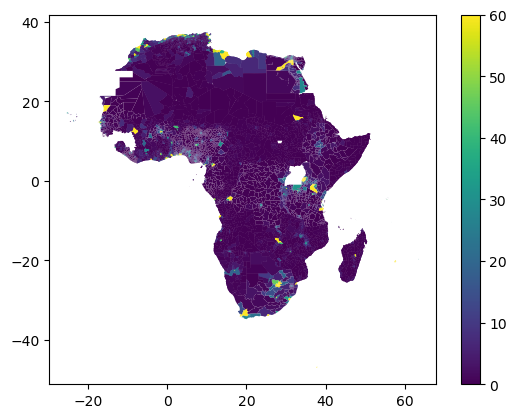

In [36]:
global_gdf.plot(column = 'cumulative', legend = True, vmin = 0, vmax = 60)